#**Programa Ciencia de los Datos TEC**

##Módulo 2: Aprendizaje Automático

##**Proyecto Final** 

###Integrantes:

*   Juan José Rojas Hernández
*   Samuel Monge Alvarado

**Noviembre, 2021**





# Introducción
## Objetivo:
* Resolver un problema de regresión que permita estimar las muertes por millón a causa de la COVID-19, por país, mediante modelos de Machine Learning.

## Enfoque: 

Para este proyecto, se utilizará una base de datos pública tomada de [_ourworldindata.org_](https://ourworldindata.org/coronavirus) específicamente de este [repositorio](https://github.com/owid/covid-19-data/tree/master/public/data). 

Este dataset fue construido por un grupo de investigadores de la salud que han recopilado información de fuentes como el _COVID-19 Data Repository by the Center for Systems Science and Engineering (CSSE)_ de la _Johns Hopkins University_, la _ONU_, el _Banco Mundial_ y datos propiamente proporcionados por gobiernos de los países en estudio. Además, tiene la funcionalidad de que los datos son actualizados diariamente, específicamente los que corresponden a tasas de vacunación, casos y muertes.


---




# Desarrollo
##Preprocesamiento
Previo a comenzar, debemos importar las siguientes librerías:

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

###Selección y captura del dataset:

Con la función *read_csv* de pandas se lee el archivo que ya se encuentra dentro del entorno de colab. Con las funciones *head* y *tail* se muestran las primeras y últimas instancias del dataset.

In [ ]:
ds = pd.read_csv('https://covid.ourworldindata.org/data/owid-covid-data.csv')
ds.tail()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
132639,ZWE,Africa,Zimbabwe,2021-11-07,133187.0,19.0,30.000,4685.0,0.0,1.000,8824.907,1.259,1.988,310.426,0.000,0.066,0.81,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1159.0,1393065.0,92.304,0.077,2879.0,0.191,0.010,96.0,tests performed,6021461.0,3372721.0,2648740.0,NaN,14436.0,15696.0,39.90,22.35,17.55,NaN,1040.0,NaN,15092171.0,42.729,19.6,2.822,1.882,1899.775,21.4,307.846,1.82,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN
132640,ZWE,Africa,Zimbabwe,2021-11-08,133205.0,18.0,28.286,4690.0,5.0,1.571,8826.099,1.193,1.874,310.757,0.331,0.104,0.82,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2242.0,1395307.0,92.452,0.149,2833.0,0.188,0.010,100.2,tests performed,6034324.0,3380245.0,2654079.0,NaN,12863.0,15858.0,39.98,22.40,17.59,NaN,1051.0,NaN,15092171.0,42.729,19.6,2.822,1.882,1899.775,21.4,307.846,1.82,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN
132641,ZWE,Africa,Zimbabwe,2021-11-09,133242.0,37.0,27.857,4691.0,1.0,1.143,8828.551,2.452,1.846,310.823,0.066,0.076,0.83,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3591.0,1398898.0,92.690,0.238,2478.0,0.164,0.011,89.0,tests performed,6056713.0,3394826.0,2661887.0,NaN,22389.0,16350.0,40.13,22.49,17.64,NaN,1083.0,NaN,15092171.0,42.729,19.6,2.822,1.882,1899.775,21.4,307.846,1.82,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN
132642,ZWE,Africa,Zimbabwe,2021-11-10,133302.0,60.0,30.143,4694.0,3.0,1.429,8832.526,3.976,1.997,311.022,0.199,0.095,0.84,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2930.0,1401828.0,92.884,0.194,2591.0,0.172,0.012,86.0,tests performed,6079213.0,3409464.0,2669749.0,NaN,22500.0,17168.0,40.28,22.59,17.69,NaN,1138.0,NaN,15092171.0,42.729,19.6,2.822,1.882,1899.775,21.4,307.846,1.82,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN
132643,ZWE,Africa,Zimbabwe,2021-11-11,133329.0,27.0,31.000,4694.0,0.0,1.286,8834.315,1.789,2.054,311.022,0.000,0.085,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6101678.0,3423588.0,2678090.0,NaN,22465.0,17988.0,40.43,22.68,17.74,NaN,1192.0,NaN,15092171.0,42.729,19.6,2.822,1.882,1899.775,21.4,307.846,1.82,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN


###Orden y selección de instancias:

Debido a que el dataset esta construido de forma que cada fila corresponde a una fecha diferente, existen muchos valores para cada país. Algunos problemas con esto:

*   No todos los países reportan datos todos los días y/o en los mismos días.
*   Existen tasas de índices repetidas ya que son datos que las organizaciones proporcionan mensualmente.
*   La intención del proyecto **NO** era abordarlo bajo series de tiempo.
*   De los 65 features del dataset, muchos cuentan con gran cantidad de NA.

Por lo tanto, como primer paso se decidió tomar como base los datos acumulados mas recientes por país. Ya que es un feature que todos los países en estudio reportaron y además de que es un valor en aumento. 

De esta forma, sólo se conservaron las instancias en las que la columna **people_fully_vaccinated_per_hundred** tuviera el valor máximo por país. 
Es decir, no necesariamente se van a comparar datos de países en las mismas fechas, pero sí se estarían utilizando los datos reportados más actualizados.




In [ ]:
#Se conservan solo los valores mas recientes por país de población con vacunación completa
indexes_to_keep = ds.groupby(['location']).people_fully_vaccinated_per_hundred.idxmax().tolist()
ds = ds.filter(items = indexes_to_keep, axis=0)

###Remoción de datos nulos (NA):
Además, se realiza una eliminación de filas con valores no numéricos en ciertas columnas que consideramos son importantes para el análisis. Esto causa que se remuevan un número importante de países del modelo. Pasamos de 207 países a 136. Con esto, abordamos el problema de los NAs.

In [ ]:
#Se eliminan valores no numericos en ciertas columnas importantes
ds = ds[ds.continent.notna()]
ds = ds[ds.gdp_per_capita.notna()]
ds = ds[ds.human_development_index.notna()]
print(len(ds))
ds = ds[ds.total_cases_per_million.notna()]
print(len(ds))
ds = ds[ds.cardiovasc_death_rate.notna()]
print(len(ds))
ds = ds[ds.life_expectancy.notna()]
print(len(ds))
ds = ds[ds.diabetes_prevalence.notna()]
print(len(ds))
ds = ds[ds.male_smokers.notna()]
print(len(ds))
ds = ds[ds.female_smokers.notna()]
print(len(ds))
ds = ds[ds.total_deaths_per_million.notna()]
print(len(ds))
#ds = ds[ds.hospital_beds_per_thousand.notna()] se reduce a 126
#print(len(ds))

181
180
178
178
178
139
139
136


###Normalización de feature (filtro):

Se pasa a una escala de 0 a 1 los datos de people_fully_vaccinated_per_hundred.

In [ ]:
#Se normaliza esta columna para ir de 0 a 1, en lugar de 0 a 100
ds.people_fully_vaccinated_per_hundred = ds.people_fully_vaccinated_per_hundred/100
ds = ds.reset_index(drop=True)

ds.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,ALB,Europe,Albania,2021-11-10,190815.0,690.0,574.571,2975.0,5.0,5.000,66418.163,240.173,199.995,1035.527,1.740,1.740,1.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1971973.0,1040015.0,913524.0,18434.0,8614.0,6481.0,68.64,36.20,0.3180,0.64,2256.0,NaN,2872934.0,104.871,38.0,13.188,8.643,11803.431,1.1,304.195,10.08,7.1,51.2,NaN,2.89,78.57,0.795,NaN,NaN,NaN,NaN
1,DZA,Africa,Algeria,2021-11-08,207254.0,98.0,98.286,5950.0,5.0,3.714,4645.219,2.196,2.203,133.358,0.112,0.083,1.10,15.0,0.336,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11316115.0,6418827.0,4897288.0,NaN,NaN,10779.0,25.36,14.39,0.1098,NaN,242.0,NaN,44616626.0,17.348,29.1,6.211,3.857,13913.839,0.5,278.364,6.73,0.7,30.4,83.741,1.90,76.88,0.748,NaN,NaN,NaN,NaN
2,ARG,South America,Argentina,2021-11-11,5302445.0,1460.0,1208.000,116209.0,25.0,22.000,116266.842,32.013,26.488,2548.118,0.548,0.482,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,62402836.0,35541742.0,26982182.0,NaN,241176.0,194593.0,136.83,77.93,0.5916,NaN,4267.0,NaN,45605823.0,16.177,31.9,11.198,7.441,18933.907,0.6,191.032,5.50,16.2,27.7,NaN,5.00,76.67,0.845,NaN,NaN,NaN,NaN
3,ARM,Asia,Armenia,2021-10-31,308326.0,1587.0,1851.143,6328.0,44.0,45.000,103878.943,534.680,623.674,2131.984,14.824,15.161,1.02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16578.0,2097421.0,706.648,5.585,14975.0,5.045,0.124,8.1,tests performed,831856.0,579360.0,252496.0,NaN,NaN,17502.0,28.03,19.52,0.0851,NaN,5897.0,NaN,2968128.0,102.931,35.7,11.232,7.571,8787.580,1.8,341.010,7.11,1.5,52.1,94.043,4.20,75.09,0.776,NaN,NaN,NaN,NaN
4,AUS,Oceania,Australia,2021-11-11,187041.0,1414.0,1378.286,1873.0,11.0,11.143,7252.964,54.831,53.446,72.630,0.427,0.432,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,163317.0,45074011.0,1747.853,6.333,153895.0,5.968,0.009,111.7,tests performed,37383955.0,19466357.0,17680831.0,236767.0,161921.0,143554.0,144.97,75.49,0.6856,0.92,5567.0,NaN,25788217.0,3.202,37.9,15.504,10.129,44648.710,0.5,107.791,5.07,13.0,16.5,NaN,3.84,83.44,0.944,NaN,NaN,NaN,NaN


###Nuevo dataset de trabajo

Se limpia el dataset originial eliminándose las columnas que se consideraron en el paso anterior no aportarán información relevante al modelo por la cantidad de datos nulos que manejan.

Es importante mantener como índice de indexación a la columna de *location*.

In [ ]:
col_list = ["location", "people_fully_vaccinated_per_hundred", "gdp_per_capita", "human_development_index", "total_cases_per_million", "cardiovasc_death_rate", "life_expectancy", "diabetes_prevalence", "male_smokers", "female_smokers", "total_deaths_per_million" ]

ds = ds[col_list]
ds = ds.set_index('location')
ds.head()

,people_fully_vaccinated_per_hundred,gdp_per_capita,human_development_index,total_cases_per_million,cardiovasc_death_rate,life_expectancy,diabetes_prevalence,male_smokers,female_smokers,total_deaths_per_million
location,,,,,,,,,,
Albania,0.3180,11803.431,0.795,66418.163,304.195,78.57,10.08,51.2,7.1,1035.527
Algeria,0.1098,13913.839,0.748,4645.219,278.364,76.88,6.73,30.4,0.7,133.358
Argentina,0.5916,18933.907,0.845,116266.842,191.032,76.67,5.50,27.7,16.2,2548.118
Armenia,0.0851,8787.580,0.776,103878.943,341.010,75.09,7.11,52.1,1.5,2131.984
Australia,0.6856,44648.710,0.944,7252.964,107.791,83.44,5.07,16.5,13.0,72.630


### Gráficas exploratorias

Se realizan las siguientes gráficas de dispersión entre las variables para explorar preliminarmente las tendencias y posibles relaciones lineales o exponenciales entre ellas. Tomando en cuenta que el feature *target* será *total_deaths_per_million*.

Para esto se utiliza la función pairplot de Seaborn que imprime todas las gráficas en una sola imagen.

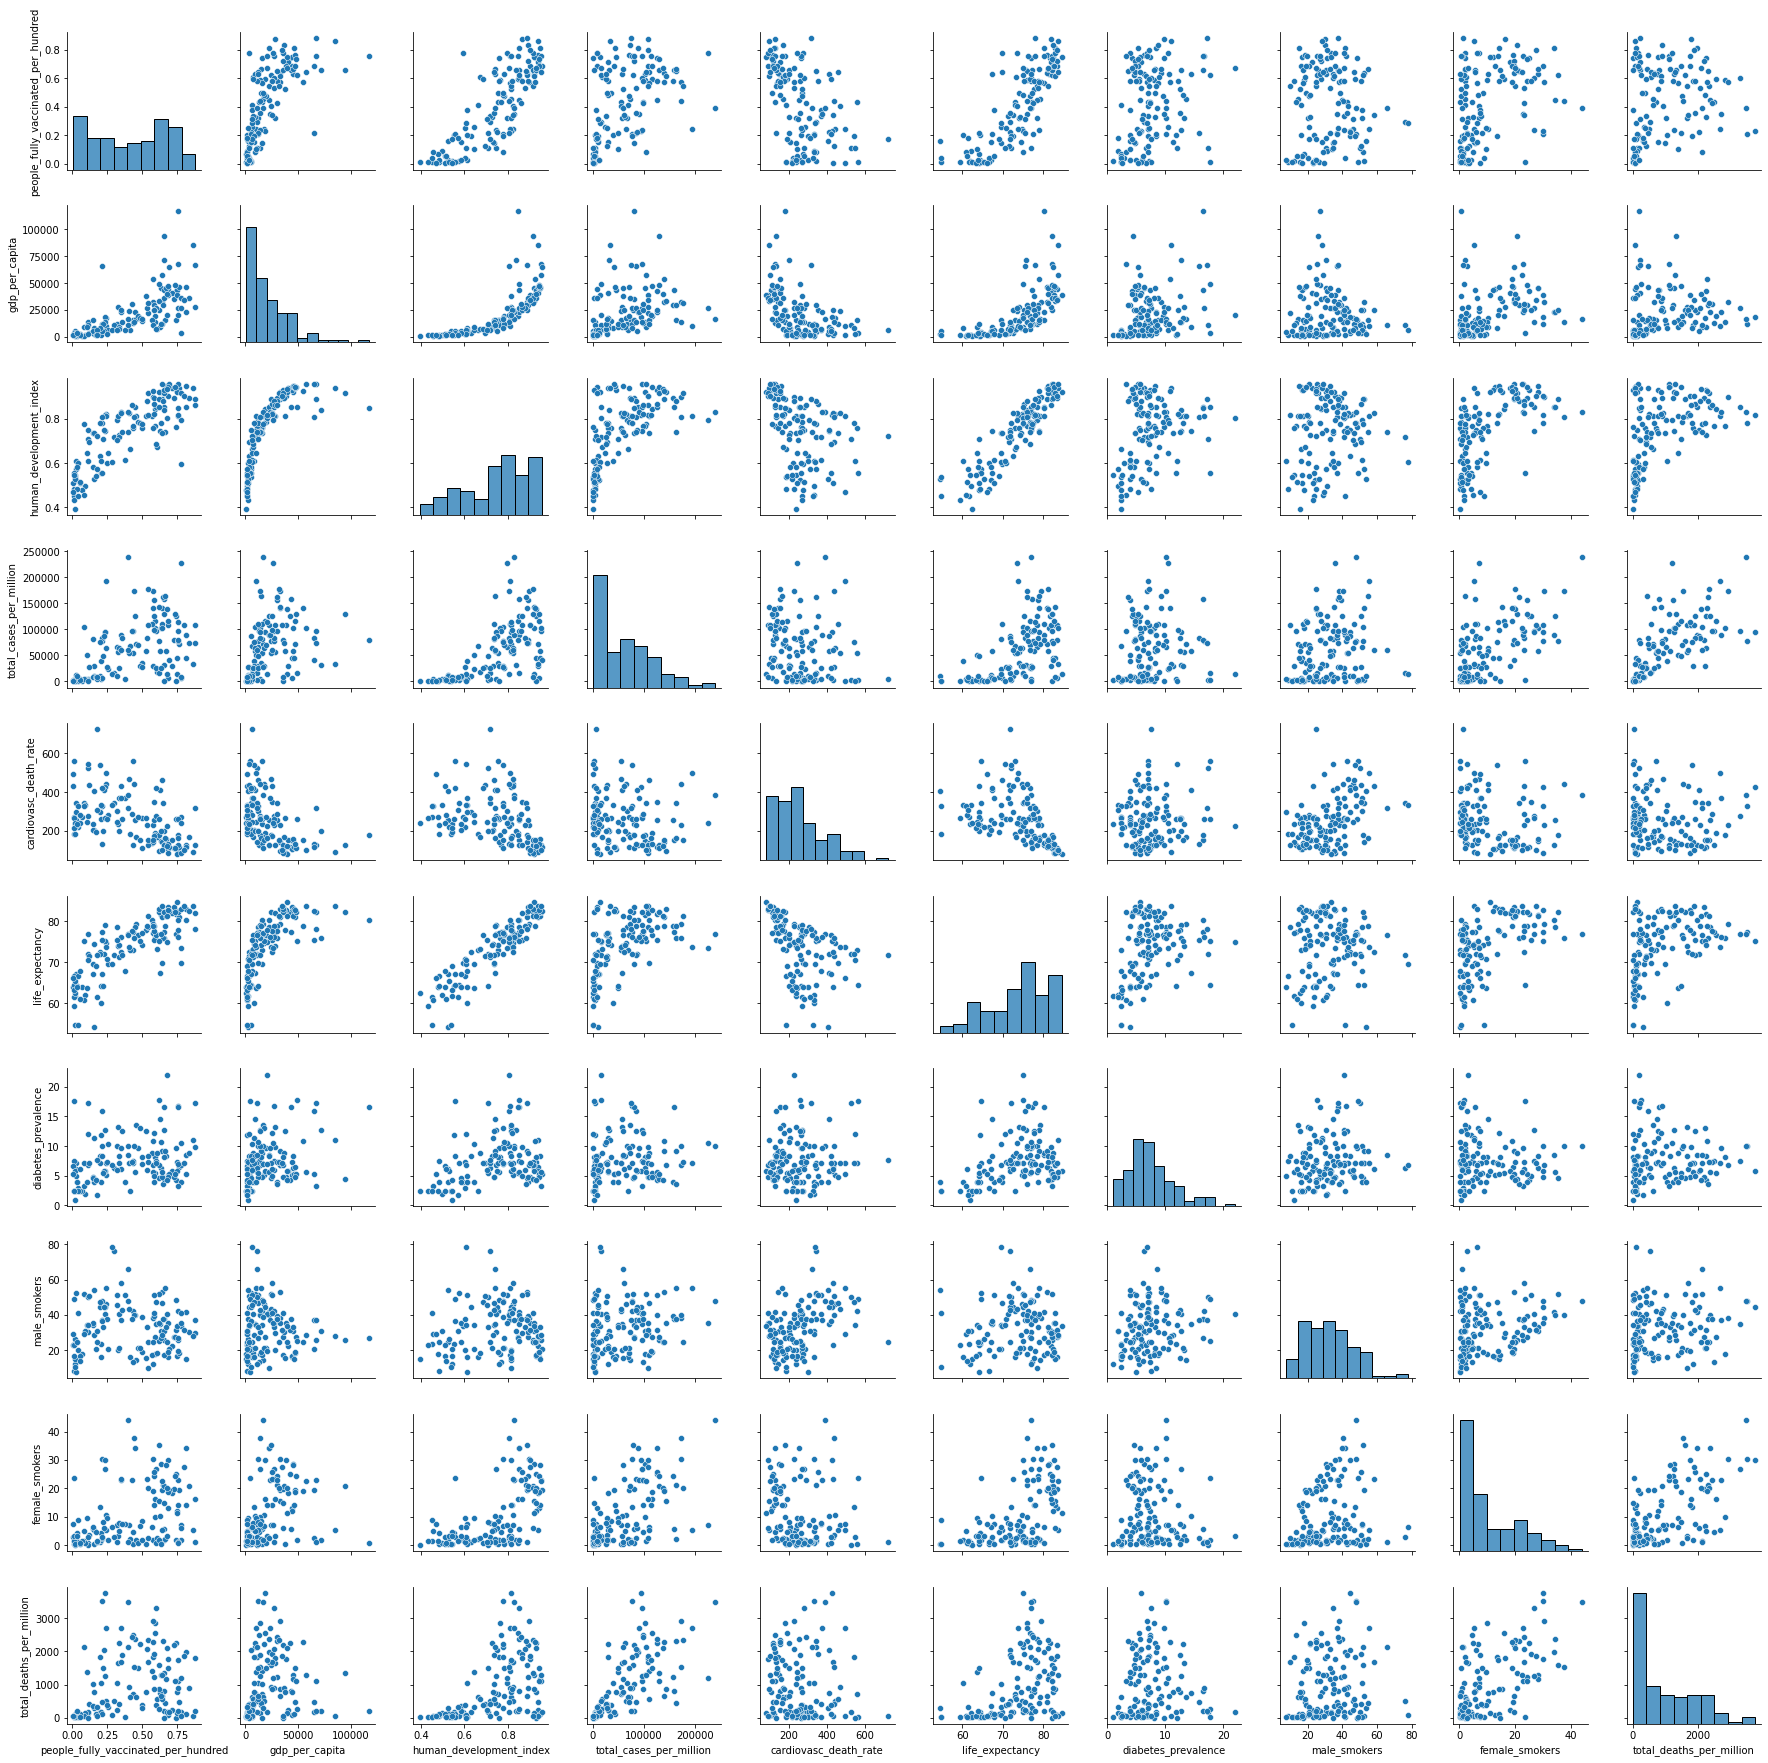

In [ ]:
sns.pairplot(ds)

###Normalización

Una vez seleccionados los features a utilizar en el modelo, se normalizan de 0 a 1 ya que todos tienen rangos de funcionamiento diferentes. Para esto se utiliza la función **MinMaxScaler**.


In [ ]:
from sklearn.preprocessing import MinMaxScaler

newds = pd.DataFrame(fit_data, columns=["people_fully_vaccinated_per_hundred", "gdp_per_capita", "human_development_index", "total_cases_per_million", "cardiovasc_death_rate", "life_expectancy", "diabetes_prevalence", "male_smokers", "female_smokers", "total_deaths_per_million"])


newds = newds.assign(location=ds.index)
ds = newds.set_index('location')

scaler = MinMaxScaler()
fit_data = scaler.fit_transform(ds)

ds.head()

,people_fully_vaccinated_per_hundred,gdp_per_capita,human_development_index,total_cases_per_million,cardiovasc_death_rate,life_expectancy,diabetes_prevalence,male_smokers,female_smokers,total_deaths_per_million
location,,,,,,,,,,
Albania,0.359182,0.095114,0.712256,0.276573,0.348540,0.800000,0.432240,0.617898,0.159453,0.274596
Algeria,0.121402,0.113279,0.628774,0.019269,0.308495,0.744224,0.272943,0.322443,0.013667,0.034626
Argentina,0.671654,0.156487,0.801066,0.484209,0.173107,0.737294,0.214456,0.284091,0.366743,0.676933
Armenia,0.093193,0.069156,0.678508,0.432609,0.405614,0.685149,0.291013,0.630682,0.031891,0.566244
Australia,0.779009,0.377818,0.976909,0.030131,0.044060,0.960726,0.194009,0.125000,0.293850,0.018473




---


## Modelo de Machine Learning

### Separación del dataset

Mediante la función *train_test_split* separo un 80% de los datos que serán los usados para entrenamiento, mientras que el restante 20% serán utilizados para probar el modelo.

Además, se definen las columnas que serán utilizadas como matriz de features y la columna que será utilizada como target.

In [ ]:
from sklearn.model_selection import train_test_split

ind = ds.index.values
y = ds[['total_deaths_per_million']].values.ravel()
newds = ds.drop(labels="total_deaths_per_million", axis=1)
X = newds.values

X_train, X_test, y_train, y_test, ind_train, ind_test = train_test_split(X,y,ind, random_state=13) 

###Explicación del abordaje

Con el set de datos ya separado, se aplican los siguientes modelos de regresión:

*   Regresión lineal
*   K-Nearest Neighbors
*   Random Forest Regressor
*   AdaBoost Regressor
*   Bagging Regressor
*   Gradient Boosting Regressor
*   Support Vector Regressor
*   Kernel Ridge
*   Voting (recopilado de varios de los anteriores).

Cada modelo se evaluó mediante las métrica del coeficiente de determinación $R^2$. Esta puede ir de 0 a 1, donde 1 corresponde a buena correlación entre los datos y el target. 

En cuanto a la selección de hiperparámetros por modelo se basó mucho en la experimentación y en consultar la documentación de la biblioteca **scikit_learn**. De esta librería se obtuvieron las funciones para cada uno de los modelos anteriomente mencionados. 

No obstante, por modelo se desarrollaron gráficas que permiten relacionar un hiperparámetro con el coeficiente $R^2$. Esto con el objetivo de entender el peso que tiene el hiperparámetro y cuáles serán sus valores óptimos que arrojen una mejor predicción. En algunos casos se obtuvo más de una gráfica ya que se trataban de modelos con varios hiperparámetros de gran importancia.

Además, la métrica $R^2$ se calculó tanto para los datos de *training* como para los de *testing*, esto con tal de evidenciar algún problema de *fitting*. Por gráfica, también se hizo una diferencia entre cada una de las curvas, una correspondiente a *training* y la otra a *testing*.


###Regresión lineal.
Se realiza regresión lineal y se evalua la regresión con los datos de entrenamiento y prueba usando $R^2$

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

reg_lin = LinearRegression().fit(X_train, y_train)

print('R^2 para datos de training: {:5.4f}'.format(reg_lin.score(X_train, y_train)))
print('R^2 para datos de testing: {:5.4f}'.format(reg_lin.score(X_test, y_test)))

y_pred_rl = reg_lin.predict(X_test)
reg_lin_rmse=mean_squared_error(y_test, y_pred_rl, squared=False)
print('RMSE para datos de testing: {:5.4f}'.format(reg_lin_rmse))

R^2 para datos de training: 0.6577
R^2 para datos de testing: 0.5793
RMSE para datos de testing: 0.1661


Estos $R^2$ obtenidos muestran cierto nivel de overfitting.

###K-Nearest Neighbors

Se realiza la regresión utilizando los k-vecinos mas cercanos, desde 1 hasta 12 vecinos evaluando la evolución del $R^2$ con los datos de entrenamiento y de prueba

Text(0.5, 1.0, 'Coeficiente de Determinación (K-Nearest Neighbors)')

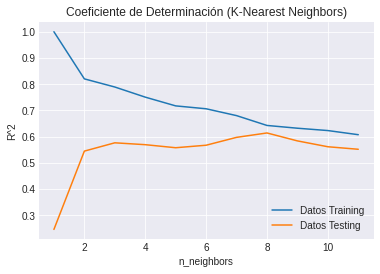

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
%matplotlib inline

training_r2 = []
test_r2 = []

neighbors_settings = range(1, 12)
for n_neighbors in neighbors_settings:
    reg_KNN2 = KNeighborsRegressor(n_neighbors=n_neighbors,
                               ).fit(X_train, y_train)
    training_r2.append(reg_KNN2.score(X_train, y_train))
    test_r2.append(reg_KNN2.score(X_test, y_test))

plt.plot(neighbors_settings, training_r2, label="Datos Training")
plt.plot(neighbors_settings, test_r2, label="Datos Testing")
plt.ylabel("R^2")
plt.xlabel("n_neighbors")
plt.legend(loc = "lower right")
plt.title('Coeficiente de Determinación (K-Nearest Neighbors)')

Con n_neighbors=8 se obtiene el mejor $R^2$ sin estar en overfitting.

In [ ]:
reg_KNN2 = KNeighborsRegressor(n_neighbors=8,
                               ).fit(X_train, y_train)

print('R^2 para datos de training: {:5.4f}'.format(reg_KNN2.score(X_train, y_train)))
print('R^2 para datos de testing: {:5.4f}'.format(reg_KNN2.score(X_test, y_test)))

y_pred_KNN2 = reg_KNN2.predict(X_test)
reg_KNN2_rmse=mean_squared_error(y_test, y_pred_KNN2, squared=False)
print('RMSE para datos de testing: {:5.4f}'.format(reg_KNN2_rmse))

R^2 para datos de training: 0.6426
R^2 para datos de testing: 0.6140
RMSE para datos de testing: 0.1591


###Random Forest


Se realiza la regresión con random forest, utilizando desde 1 hasta 50 estimadores y evaluando la evolución del $R^2$ con los datos de entrenamiento y de prueba

Text(0.5, 1.0, 'Coeficiente de Determinación (Random Forest)')

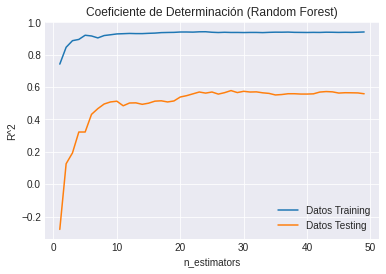

In [ ]:
from sklearn.ensemble import RandomForestRegressor

training_r2 = []
test_r2 = []

n_estimators = range(1,50,1)
for estimator in n_estimators:
    reg_rf = RandomForestRegressor(max_depth=6, 
                               n_estimators=estimator, 
                               random_state=0).fit(X_train, y_train)
    training_r2.append(reg_rf.score(X_train, y_train))
    test_r2.append(reg_rf.score(X_test, y_test))

plt.plot(n_estimators, training_r2, label="Datos Training")
plt.plot(n_estimators, test_r2, label="Datos Testing")
plt.ylabel("R^2")
plt.xlabel("n_estimators")
plt.legend(loc = "lower right")
plt.title('Coeficiente de Determinación (Random Forest)')

Se puede observar que no se obtienen mejoras por encima de los 30 estimadores, ahora se modifica la profundidad dejando los estimadores en un valor de 30 y se evalua el $R^2$ con los datos de entrenamiento y de prueba

Text(0.5, 1.0, 'Coeficiente de Determinación (Random Forest)')

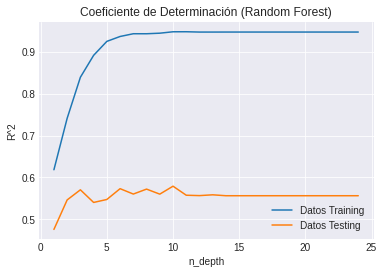

In [ ]:
training_r2 = []
test_r2 = []

n_depth = range(1,25,1)
for depth in n_depth:
    reg_rf = RandomForestRegressor(max_depth=depth, 
                               n_estimators=30, 
                               random_state=0).fit(X_train, y_train)
    training_r2.append(reg_rf.score(X_train, y_train))
    test_r2.append(reg_rf.score(X_test, y_test))

plt.plot(n_depth, training_r2, label="Datos Training")
plt.plot(n_depth, test_r2, label="Datos Testing")
plt.ylabel("R^2")
plt.xlabel("n_depth")
plt.legend(loc = "lower right")
plt.title('Coeficiente de Determinación (Random Forest)')

En este caso se observa que no se obtiene mejora por encima de una profundidad de 10.

In [ ]:
reg_rf = RandomForestRegressor(max_depth=10, 
                               n_estimators=50, 
                               random_state=0).fit(X_train, y_train)

print('R^2 para datos de training: {:5.4f}'.format(reg_rf.score(X_train, y_train)))
print('R^2 para datos de testing: {:5.4f}'.format(reg_rf.score(X_test, y_test)))

y_pred_rf = reg_rf.predict(X_test)
reg_rf_rmse=mean_squared_error(y_test, y_pred_rf, squared=False)
print('RMSE para datos de testing: {:5.4f}'.format(reg_rf_rmse))

R^2 para datos de training: 0.9514
R^2 para datos de testing: 0.5595
RMSE para datos de testing: 0.1699


Con este método se obtiene un $R^2$ muy bueno para los datos de entrenamiento, pero muy malo con los datos de testing. Otro evidente caso de overfitting.

###AdaBoost Regressor

Se realiza la regresión con adaboost, utilizando desde 1 hasta 100 estimadores y evaluando la evolución del $R^2$ con los datos de entrenamiento y de prueba

Text(0.5, 1.0, 'Coeficiente de Determinación (Boosting)')

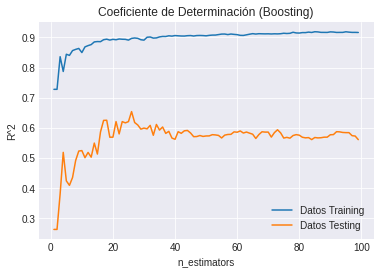

In [ ]:
from sklearn.ensemble import AdaBoostRegressor

training_r2 = []
test_r2 = []

n_estimators = range(1,100,1)
for estimator in n_estimators:
    reg_adbr = AdaBoostRegressor(n_estimators=estimator, 
                             learning_rate=1.0, 
                             loss='square', 
                             random_state=0).fit(X_train, y_train)
    training_r2.append(reg_adbr.score(X_train, y_train))
    test_r2.append(reg_adbr.score(X_test, y_test))

plt.plot(n_estimators, training_r2, label="Datos Training")
plt.plot(n_estimators, test_r2, label="Datos Testing")
plt.ylabel("R^2")
plt.xlabel("n_estimators")
plt.legend(loc = "lower right")
plt.title('Coeficiente de Determinación (Boosting)')

Se puede observar que no se obtienen grandes diferencias en por encima de los 25 estimadores, ahora se modifica la taza de aprendizaje de 0.1 a 1.5 en pasos de 0.1, dejando los estimadores en un valor de 25 y se evalua el $R^2$ con los datos de entrenamiento y de prueba

Text(0.5, 1.0, 'Coeficiente de Determinación (Boosting)')

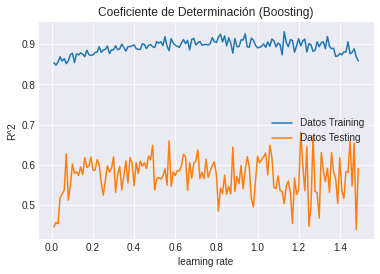

In [ ]:
training_r2 = []
test_r2 = []

learning_rate = range(1,150,1)
lrlist = np.array([*learning_rate])/100


for learning in learning_rate:
    learning /= 100
    reg_adbr = AdaBoostRegressor(n_estimators=25, 
                             learning_rate=learning, 
                             loss='square', 
                             random_state=0).fit(X_train, y_train)
    training_r2.append(reg_adbr.score(X_train, y_train))
    test_r2.append(reg_adbr.score(X_test, y_test))

plt.plot(lrlist, training_r2, label="Datos Training")
plt.plot(lrlist, test_r2, label="Datos Testing")
plt.ylabel("R^2")
plt.xlabel("learning rate")
plt.legend(loc = "center right")
plt.title('Coeficiente de Determinación (Boosting)')

El comportamiento es caótico, al modificar en este paso la tasa de aprendizaje. Y tampoco se mejora significativamente el $R^2$, por lo tanto, se elige una taza de 0.1:

In [ ]:
reg_adbr = AdaBoostRegressor(n_estimators=25, 
                             learning_rate=0.1, 
                             loss='square', 
                             random_state=0).fit(X_train, y_train)

print('R^2 para datos de training: {:5.4f}'.format(reg_adbr.score(X_train, y_train)))
print('R^2 para datos de testing: {:5.4f}'.format(reg_adbr.score(X_test, y_test)))

y_pred_adbr = reg_adbr.predict(X_test)
reg_adbr_rmse=mean_squared_error(y_test, y_pred_adbr, squared=False)
print('RMSE para datos de testing: {:5.4f}'.format(reg_adbr_rmse))

R^2 para datos de training: 0.8773
R^2 para datos de testing: 0.6019
RMSE para datos de testing: 0.1616


Sin embargo, sigue existiendo overfitting y $R^2$ bajos.

###Bagging Regressor

Se realiza la regresión con bagging, utilizando desde 1 hasta 100 estimadores y evaluando la evolución del $R^2$ con los datos de entrenamiento y de prueba

Text(0.5, 1.0, 'Coeficiente de Determinación (Bagging)')

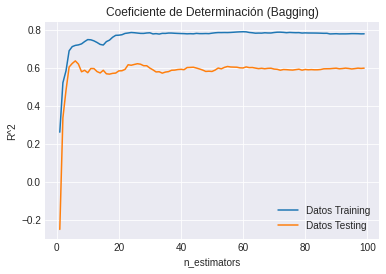

In [ ]:
from sklearn.ensemble import BaggingRegressor

training_r2 = []
test_r2 = []

n_estimators = range(1,100,1)
for estimator in n_estimators:
    reg_bag = BaggingRegressor(n_estimators=estimator, 
                           max_samples=25, 
                           random_state=0).fit(X_train, y_train)
    training_r2.append(reg_bag.score(X_train, y_train))
    test_r2.append(reg_bag.score(X_test, y_test))

plt.plot(n_estimators, training_r2, label="Datos Training")
plt.plot(n_estimators, test_r2, label="Datos Testing")
plt.ylabel("R^2")
plt.xlabel("n_estimators")
plt.legend(loc = "lower right")
plt.title('Coeficiente de Determinación (Bagging)')

Se puede observar que no se obtienen grandes diferencias en por encima de los 25 estimadores, ahora se modifica la cantidad de muestras desde 1 a 100, dejando los estimadores en un valor de 25 y se evalua el $R^2$ con los datos de entrenamiento y de prueba

Text(0.5, 1.0, 'Coeficiente de Determinación (Bagging)')

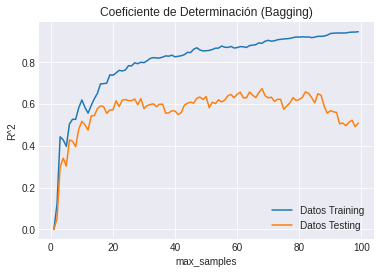

In [ ]:
training_r2 = []
test_r2 = []

max_samples = range(1,100,1)
for sample in max_samples:
    reg_bag = BaggingRegressor(n_estimators=25, 
                           max_samples=sample, 
                           random_state=0).fit(X_train, y_train)
    training_r2.append(reg_bag.score(X_train, y_train))
    test_r2.append(reg_bag.score(X_test, y_test))

plt.plot(max_samples, training_r2, label="Datos Training")
plt.plot(max_samples, test_r2, label="Datos Testing")
plt.ylabel("R^2")
plt.xlabel("max_samples")
plt.legend(loc = "lower right")
plt.title('Coeficiente de Determinación (Bagging)')

Se puede observar que cerca de las 30 muestras se obtiene el mejor resultado, por encima de eso se observa overfitting

In [ ]:
reg_bag = BaggingRegressor(n_estimators=25, 
                           max_samples=30, 
                           random_state=0).fit(X_train, y_train)

print('R^2 para datos de training: {:5.4f}'.format(reg_bag.score(X_train, y_train)))
print('R^2 para datos de testing: {:5.4f}'.format(reg_bag.score(X_test, y_test)))

y_pred_bag = reg_bag.predict(X_test)
reg_bag_rmse=mean_squared_error(y_test, y_pred_bag, squared=False)
print('RMSE para datos de testing: {:5.4f}'.format(reg_bag_rmse))

R^2 para datos de training: 0.7986
R^2 para datos de testing: 0.5785
RMSE para datos de testing: 0.1662


Se obtiene overfitting y coeficientes $R^2$ menores a los modelos anteriores.

###Gradient Boosting Regressor

Se realiza la regresión con gradient boosting, utilizando desde 1 hasta 50 estimadores y evaluando la evolución del $R^2$ con los datos de entrenamiento y de prueba

Text(0.5, 1.0, 'Coeficiente de Determinación (Gradient Boosting)')

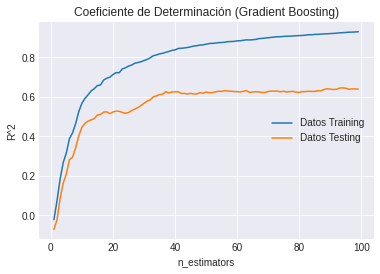

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

training_r2 = []
test_r2 = []

n_estimators = range(1,100,1)
for estimator in n_estimators:
    reg_gb = GradientBoostingRegressor(loss='huber', 
                                learning_rate=0.1, 
                                n_estimators=estimator, 
                                subsample=0.5, 
                                random_state=0, 
                                max_depth=2, 
                                max_features='sqrt').fit(X_train, y_train)
    training_r2.append(reg_gb.score(X_train, y_train))
    test_r2.append(reg_gb.score(X_test, y_test))

plt.plot(n_estimators, training_r2, label="Datos Training")
plt.plot(n_estimators, test_r2, label="Datos Testing")
plt.ylabel("R^2")
plt.xlabel("n_estimators")
plt.legend(loc = "center right")
plt.title('Coeficiente de Determinación (Gradient Boosting)')

Se puede observar que no se obtienen grandes diferencias en por encima de los 30 estimadores, ahora se modifica la profundidad 1 a 100, dejando los estimadores en un valor de 30 y se evalua el $R^2$ con los datos de entrenamiento y de prueba

Text(0.5, 1.0, 'Coeficiente de Determinación (Gradient Boosting)')

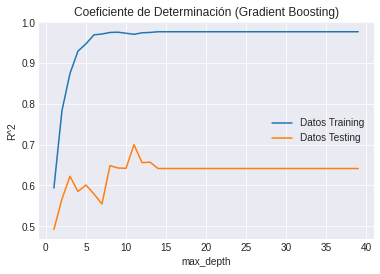

In [ ]:
training_r2 = []
test_r2 = []

max_depth = range(1,40,1)
for depth in max_depth:
    reg_gb = GradientBoostingRegressor(loss='huber', 
                                learning_rate=0.1, 
                                n_estimators=30, 
                                subsample=0.5, 
                                random_state=0, 
                                max_depth=depth, 
                                max_features='sqrt').fit(X_train, y_train)
    training_r2.append(reg_gb.score(X_train, y_train))
    test_r2.append(reg_gb.score(X_test, y_test))

plt.plot(max_depth, training_r2, label="Datos Training")
plt.plot(max_depth, test_r2, label="Datos Testing")
plt.ylabel("R^2")
plt.xlabel("max_depth")
plt.legend(loc = "center right")
plt.title('Coeficiente de Determinación (Gradient Boosting)')

Se puede observar que no se obtienen grandes diferencias en por encima de un profundidad de 15, ahora se modifica la taza de aprendizaje de 0.1 a 0.5 en pasos de 0.1, dejando los estimadores en un valor de 30 y la profundidad en 15 y se evalua el $R^2$ con los datos de entrenamiento y de prueba

Text(0.5, 1.0, 'Coeficiente de Determinación (Gradient Boosting)')

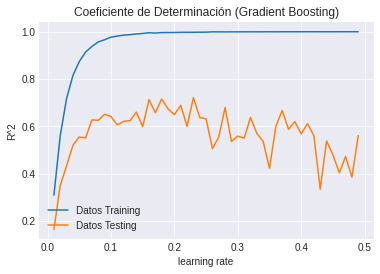

In [ ]:
training_r2 = []
test_r2 = []

learning_rate = range(1,50,1)
lrlist = np.array([*learning_rate])/100

for learning in learning_rate:
    learning /= 100 
    reg_gb = GradientBoostingRegressor(loss='huber', 
                                learning_rate=learning, 
                                n_estimators=30, 
                                subsample=0.5, 
                                random_state=0, 
                                max_depth=15, 
                                max_features='sqrt').fit(X_train, y_train)
    training_r2.append(reg_gb.score(X_train, y_train))
    test_r2.append(reg_gb.score(X_test, y_test))

plt.plot(lrlist, training_r2, label="Datos Training")
plt.plot(lrlist, test_r2, label="Datos Testing")
plt.ylabel("R^2")
plt.xlabel("learning rate")
plt.legend(loc = "lower left")
plt.title('Coeficiente de Determinación (Gradient Boosting)')

Se observa que el mejor comportamiento se obtiene alrededor de 0.15

In [ ]:
reg_gb = GradientBoostingRegressor(learning_rate=0.15, 
                                n_estimators=30, 
                                subsample=0.5, 
                                random_state=0, 
                                max_depth=15, 
                                max_features='sqrt').fit(X_train, y_train)

print('R^2 para datos de training: {:5.4f}'.format(reg_gb.score(X_train, y_train)))
print('R^2 para datos de testing: {:5.4f}'.format(reg_gb.score(X_test, y_test)))

y_pred_gb = reg_gb.predict(X_test)
reg_gb_rmse=mean_squared_error(y_test, y_pred_gb, squared=False)
print('RMSE para datos de testing: {:5.4f}'.format(reg_gb_rmse))

R^2 para datos de training: 0.9944
R^2 para datos de testing: 0.6886
RMSE para datos de testing: 0.1429


De esta forma, se obtiene un $R^2$ casi perfecto para el set de entrenamiento pero el de prueba sigue estando muy bajo.

### Support Vector Regression

Se evalúa este modelo con un rango para C que va de 0 a 100. Se parte de un kernel de tipo **rbf** y un grado de 1 para el kernel.

Text(0.5, 1.0, 'Coeficiente de Determinación (Support Vector Regressor)')

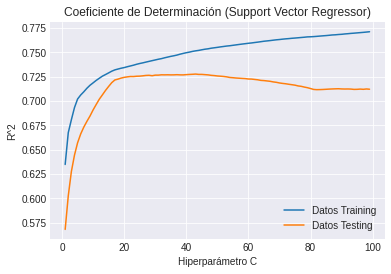

In [ ]:
from sklearn.svm import SVR

training_r2 = []
test_r2 = []

C_list = range(1,100,1)
for C in C_list:
    reg_SVR = SVR(kernel='rbf', 
              degree=1,
              gamma='auto',
              tol=0.001,
              C=C).fit(X_train, y_train)
    training_r2.append(reg_SVR.score(X_train, y_train))
    test_r2.append(reg_SVR.score(X_test, y_test))

plt.plot(C_list, training_r2, label="Datos Training")
plt.plot(C_list, test_r2, label="Datos Testing")
plt.ylabel("R^2")
plt.xlabel("Hiperparámetro C")
plt.legend(loc = "lower right")
plt.title('Coeficiente de Determinación (Support Vector Regressor)')

El mejor valor de C que evita el overfitting y ofrece un $R^2$ más aceptable es de 20. Se hicieron varias pruebas más modificando el grado del kernel y la tolerancia, sin embargo el resultado fue muy similar.

In [ ]:
reg_SVR = SVR(kernel='rbf', 
              degree=1,
              gamma='auto',
              tol=0.001,
              C=20).fit(X_train, y_train)

print('R^2 para datos de training: {:5.4f}'.format(reg_SVR.score(X_train, y_train)))
print('R^2 para datos de testing: {:5.4f}'.format(reg_SVR.score(X_test, y_test)))

y_pred_SVR = reg_SVR.predict(X_test)
reg_SVR_rmse=mean_squared_error(y_test, y_pred_SVR, squared=False)
print('RMSE para datos de testing: {:5.4f}'.format(reg_SVR_rmse))

R^2 para datos de training: 0.7343
R^2 para datos de testing: 0.7242
RMSE para datos de testing: 0.1345


Se obtiene un $R^2$ considerablemente superior a los demás y no se evidencia overfitting.

### Kernel Ridge

Se evalúa el modelo Kernel Ridge, en el cual se utiliza también un kernel de tipo **rbf**, buscando mejorar los resultados del modelo anterior. Se gráfica la variación con respecto al hiperparámetro alpha el cual va de 0 a 1.

Text(0.5, 1.0, 'Coeficiente de Determinación (Kernel Ridge)')

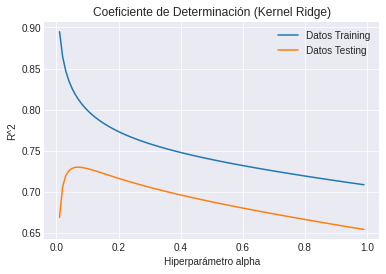

In [ ]:
from sklearn.kernel_ridge import KernelRidge

training_r2 = []
test_r2 = []

alpha_list = range(1,100,1)
alpha_lists = np.array([*alpha_list])/100

for alpha in alpha_list:
    alpha /= 100
    reg_kr = KernelRidge(kernel="rbf", 
                     alpha=alpha, 
                     gamma=0.7).fit(X_train, y_train)

    training_r2.append(reg_kr.score(X_train, y_train))
    test_r2.append(reg_kr.score(X_test, y_test))

plt.plot(alpha_lists, training_r2, label="Datos Training")
plt.plot(alpha_lists, test_r2, label="Datos Testing")
plt.ylabel("R^2")
plt.xlabel("Hiperparámetro alpha")
plt.legend(loc = "upper right")
plt.title('Coeficiente de Determinación (Kernel Ridge)')

Claramente se visualiza un máximo en la curva de testing en el 0.05. Se fija este valor y se hace la misma prueba con gamma yendo de 0 a 1.

Text(0.5, 1.0, 'Coeficiente de Determinación (Kernel Ridge)')

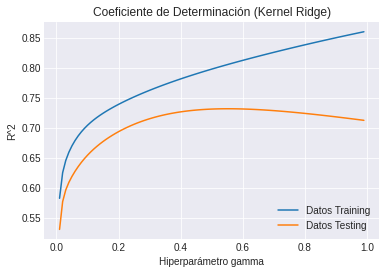

In [ ]:
training_r2 = []
test_r2 = []

gamma_list = range(1,100,1)
gamma_lists = np.array([*gamma_list])/100

for gamma in gamma_list:
    gamma /= 100
    reg_kr = KernelRidge(kernel="rbf", 
                     alpha=0.05, 
                     gamma=gamma).fit(X_train, y_train)

    training_r2.append(reg_kr.score(X_train, y_train))
    test_r2.append(reg_kr.score(X_test, y_test))

plt.plot(gamma_lists, training_r2, label="Datos Training")
plt.plot(gamma_lists, test_r2, label="Datos Testing")
plt.ylabel("R^2")
plt.xlabel("Hiperparámetro gamma")
plt.legend(loc = "lower right")
plt.title('Coeficiente de Determinación (Kernel Ridge)')

Se toma como máximo gamma igual a 0.5. Por lo tanto se combinan ambos hiperparámetros y se obtiene: 

In [ ]:
reg_kr = KernelRidge(kernel="rbf", 
                     alpha=0.05, 
                     gamma=0.5).fit(X_train, y_train)

print('R^2 para datos de training: {:5.4f}'.format(reg_kr.score(X_train, y_train)))
print('R^2 para datos de testing: {:5.4f}'.format(reg_kr.score(X_test, y_test)))

y_pred_kr = reg_kr.predict(X_test)
reg_kr_rmse=mean_squared_error(y_test, y_pred_kr, squared=False)
print('RMSE para datos de testing: {:5.4f}'.format(reg_kr_rmse))


R^2 para datos de training: 0.7981
R^2 para datos de testing: 0.7313
RMSE para datos de testing: 0.1327


Se obtiene una ligera mejoría del $R^2$ de testing con respecto al modelo de **SVR**, sin embargo en este caso el overfitting es también mayor. En cuanto al RMSE están prácticamente iguales.

### Resumen de modelos y Voting

Para culminar se utiliza el método voting que combina los resultados de los tres mejores modelos y según los pesos que definimos "votan" y se obtiene una respuesta generalizada que contempla los criterios y parámetros de cada modelo.


In [ ]:
from sklearn.ensemble import VotingRegressor
from sklearn.metrics import r2_score

reg_voting = VotingRegressor(estimators=
                              [('gb', reg_gb),
                               ('svr', reg_SVR),
                               ('kr', reg_kr)],
                             #weights=[reg_lin_rmse,reg_KNN2_rmse,reg_rf_rmse,reg_adbr_rmse,reg_bag_rmse,reg_gb_rmse,reg_SVR_rmse,reg_kr_rmse]
                             weights=[1,1.5,2])

print("R^2 de training por método:\n")
i=1
for reg in (reg_lin, reg_KNN2, reg_rf, reg_adbr, reg_bag, reg_gb, reg_SVR, reg_kr, reg_voting):
  reg.fit(X_train, y_train)
  y_pred_train = reg.predict(X_train)
  print(i,"-",reg.__class__.__name__, '{:5.4f}'.format(r2_score(y_train, y_pred_train)))
  i+=1

R^2 de training por método:

1 - LinearRegression 0.6577
2 - KNeighborsRegressor 0.6426
3 - RandomForestRegressor 0.9514
4 - AdaBoostRegressor 0.8773
5 - BaggingRegressor 0.7986
6 - GradientBoostingRegressor 0.9944
7 - SVR 0.7343
8 - KernelRidge 0.7981
9 - VotingRegressor 0.8572


En cuanto a testing, estos son los resultados generales obtenidos por modelo:

In [ ]:
print("R^2 de testing por método:\n")
i=1
for reg in (reg_lin, reg_KNN2, reg_rf, reg_adbr, reg_bag, reg_gb, reg_SVR, reg_kr, reg_voting):
  reg.fit(X_train, y_train)
  y_pred_test = reg.predict(X_test)
  print(i,"-",reg.__class__.__name__, '{:5.4f}'.format(r2_score(y_test, y_pred_test)))
  i+=1

y_pred_vot = reg_voting.predict(X_test)
rmse=mean_squared_error(y_test, y_pred_vot, squared=False)
print('\nRMSE para datos de testing con Voting: {:5.4f}'.format(rmse))

R^2 de testing por método:

1 - LinearRegression 0.5793
2 - KNeighborsRegressor 0.6140
3 - RandomForestRegressor 0.5595
4 - AdaBoostRegressor 0.6019
5 - BaggingRegressor 0.5785
6 - GradientBoostingRegressor 0.6886
7 - SVR 0.7242
8 - KernelRidge 0.7313
9 - VotingRegressor 0.7424

RMSE para datos de testing con Voting: 0.1299


Se incluye un gráfico de las predicciones normalizadas de muertes por millón para el set de pruebas usando el método Voting

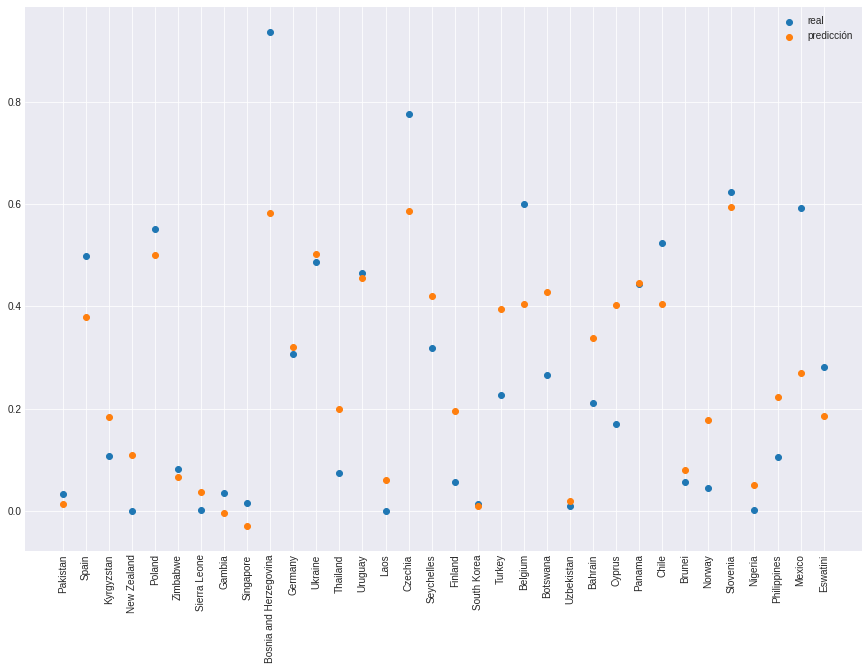

In [ ]:
plt.figure(figsize=(15,10))
plt.scatter(ind_test, y_test, label="real")
plt.scatter(ind_test, y_pred_vot, label="predicción")
plt.tick_params(axis='x', labelrotation=90)
plt.legend()
plt.show()

#Conclusión

Luego de desarrollar los modelos anteriores para resolver este problema de regresión, se concluye lo siguiente:


1.   Con los datos y features utilizados se evidencia que el $R^2$ máximo para predecir los datos de prueba tiende a 75%  
2.   A través de la experimentación se puede mejorar el desempeño de los modelos; sin embargo, en este caso el set de datos es finito (la cantidad de paises) y por lo tanto no se puede hacer mucho mas para mejorar el entrenamiento del modelo. 


---



#Bibliografía

Hannah Ritchie, Edouard Mathieu, Lucas Rodés-Guirao, Cameron Appel, Charlie Giattino, Esteban Ortiz-Ospina, Joe Hasell, Bobbie Macdonald, Diana Beltekian and Max Roser (2020) - "Coronavirus Pandemic (COVID-19)". Published online at OurWorldInData.org. Retrieved from: 'https://ourworldindata.org/coronavirus' [Online Resource]



---

